In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
df_visits = pd.read_csv('visits_us.csv', parse_dates=['date']) #, dtype={'group':'category'}
df_orders = pd.read_csv('orders_us.csv', parse_dates=['date']) #, dtype={'group':'category'}
df_hypotheses = pd.read_csv('hypotheses_us.csv', sep=';')

In [3]:
df_dict = {'df_visits':df_visits, 'df_orders':df_orders, 'df_hypotheses':df_hypotheses}

In [4]:
for name, df in df_dict.items():
#     df.columns = df.columns.str.lower()
    print('\n', name,'info:\n**************************************************\n')    
    print(df.info())
    print('\n', name,'head:\n**************************************************\n')
    print(df.head())
    print('\n', name,'duplicated:\n**************************************************\n')
    print(df.duplicated().sum())


 df_visits info:
**************************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date      62 non-null datetime64[ns]
group     62 non-null object
visits    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None

 df_visits head:
**************************************************

        date group  visits
0 2019-08-01     A     719
1 2019-08-02     A     619
2 2019-08-03     A     507
3 2019-08-04     A     717
4 2019-08-05     A     756

 df_visits duplicated:
**************************************************

0

 df_orders info:
**************************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null float64
group          

## Part 1. Prioritizing Hypotheses

In [5]:
df_hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


#### Apply the ICE and RICE frameworks to prioritize hypotheses:

In [6]:
df_hypotheses['ICE'] = round(df_hypotheses['Impact'] * df_hypotheses['Confidence'] / df_hypotheses['Effort'], 1)
df_hypotheses['RICE'] = df_hypotheses['Reach'] * df_hypotheses['Impact'] * df_hypotheses['Confidence'] / df_hypotheses['Effort']

#### Sort hypotheses in descending order of priority by ICE column:

In [7]:
# function to highlight max values in each column:

def highlight_max(s):    
    is_max = s == s.max()
    return ['background-color: lightblue' if i else '' for i in is_max]

df_hypotheses.set_index('Hypothesis').sort_values('ICE', ascending=False).style.apply(highlight_max)

,Reach,Impact,Confidence,Effort,ICE,RICE
Hypothesis,,,,,,
Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.2,16.2
Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.3,40
Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.2,112
Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8,40
Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7,56
Launch your own delivery service. This will shorten delivery time,2,5,4,10,2,4
Add a customer review page. This will increase the number of orders,3,2,2,3,1.3,4
Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.1,9
Change the background color on the main page. This will increase user engagement,3,1,1,1,1,3


#### We can see that the prioritization of hypotheses changes when we use `RICE` instead of `ICE`. 

The `'Reach'` parameter has significant impact on results.

Let's add ranks to the table:

In [8]:
df_hypotheses['rank_ICE'] = df_hypotheses['ICE'].rank(method='min', ascending=False).astype(int)
df_hypotheses['rank_RICE'] = df_hypotheses['RICE'].rank(method='min', ascending=False).astype(int)

In [9]:
df_hypotheses.sort_values('RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Effort,ICE,RICE,rank_ICE,rank_RICE
7,Add a subscription form to all the main pages....,10,7,8,5,11.2,112.0,3,1
2,Add product recommendation blocks to the store...,8,3,7,3,7.0,56.0,5,2
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.3,40.0,2,3
6,Show banners with current offers and sales on ...,5,3,8,3,8.0,40.0,4,3
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.2,16.2,1,5
3,Change the category structure. This will incre...,8,3,3,8,1.1,9.0,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10,2.0,4.0,6,7
5,Add a customer review page. This will increase...,3,2,2,3,1.3,4.0,7,7
4,Change the background color on the main page. ...,3,1,1,1,1.0,3.0,9,9


#### The difference between `ICE` and `RICE` ranks shows us how strongly the `'Reach'` parameter can influence hypothesis prioritization:

    rank_ICE  rank_RICE
         3          1
         5          2
         2          3
         4          3
         1          5

#### xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

## Part 2. A/B Test Analysis

### Preparing tables for calculation

In [10]:
df_visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [11]:
df_orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


#### Cumulative Data:

In [12]:
# new df
cum_orders = df_orders.groupby(['group','date']).agg({'visitorId':'nunique',
                                                      'transactionId':'nunique',
                                                      'revenue':'sum'}).groupby(level=0).cumsum().reset_index()


cum_orders = cum_orders.sort_values(by=['date', 'group']).reset_index()

# reorder columns
cum_orders = cum_orders[['date', 'group', 'transactionId', 'visitorId', 'revenue']]


cum_visits = df_visits.groupby(['group','date']).agg({'visits':'sum'}).groupby(level=0).cumsum().reset_index()

# new df
cum_data = cum_orders.merge(cum_visits, on=['date','group'])

# rename columns
cum_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# new column 'avgerage purchase size'
cum_data['avg_purchase_size'] = round(cum_data.revenue / cum_data.orders, 2)

# calculating conversion
# Buyer Conversion Rate:
cum_data['buyer_conversion'] = cum_data['buyers']/cum_data['visitors']

# Order Conversion Rate:
cum_data['order_conversion'] = cum_data['orders']/cum_data['visitors']


cum_data.head(3)

,date,group,orders,buyers,revenue,visitors,avg_purchase_size,buyer_conversion,order_conversion
0,2019-08-01,A,24,20,2356.8,719,98.20,0.027816,0.033380
1,2019-08-01,B,21,20,1620.0,713,77.14,0.028050,0.029453
2,2019-08-02,A,44,39,3860.3,1338,87.73,0.029148,0.032885


#### Cumulative Data pivoted:

In [13]:
cum_data_pivoted = cum_data.pivot_table(index='date', 
                                        columns='group', 
                                        values=['orders','buyers','revenue','visitors','avg_purchase_size',
                                                'buyer_conversion','order_conversion']).reset_index()

cum_data_pivoted.columns = [''.join(i) for i in cum_data_pivoted.columns]


cum_data_pivoted.head(3)

,date,avg_purchase_sizeA,avg_purchase_sizeB,buyer_conversionA,buyer_conversionB,buyersA,buyersB,order_conversionA,order_conversionB,ordersA,ordersB,revenueA,revenueB,visitorsA,visitorsB
0,2019-08-01,98.20,77.14,0.027816,0.028050,20,20,0.033380,0.029453,24,21,2356.8,1620.0,719,713
1,2019-08-02,87.73,94.31,0.029148,0.033230,39,43,0.032885,0.034776,44,45,3860.3,4243.8,1338,1294
2,2019-08-03,83.46,99.19,0.034146,0.032723,63,59,0.036856,0.033833,68,61,5675.5,6050.6,1845,1803


#### xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

#### Aggregated Data:

In [14]:
# new df
agg_data = df_visits.merge(df_orders.groupby(['visitorId','date','group'], as_index=False)\
                                    .agg({'transactionId':'nunique','revenue':'sum'})\
                                    .groupby(['date', 'group'], as_index=False)\
                                    .agg({'visitorId':'nunique','transactionId':'sum','revenue':'sum'}),
                           on=['date', 'group'])

# rename columns
agg_data.columns = ['date','group','visitors','buyers','orders','revenue']

# new column 'avgerage purchase size'
agg_data['avg_purchase_size'] = round(agg_data['revenue'] / agg_data['orders'], 2)

# calculating conversion
# Buyer Conversion Rate:
agg_data['buyer_conversion'] = agg_data['buyers']/agg_data['visitors']

# Order Conversion Rate:
agg_data['order_conversion'] = agg_data['orders']/agg_data['visitors']

# new column 'not_buyers' - visitors without orders
agg_data['not_buyers'] = agg_data['visitors'] - agg_data['buyers']

agg_data.head(3)

,date,group,visitors,buyers,orders,revenue,avg_purchase_size,buyer_conversion,order_conversion,not_buyers
0,2019-08-01,A,719,20,24,2356.8,98.20,0.027816,0.033380,699
1,2019-08-02,A,619,19,20,1503.5,75.18,0.030695,0.032310,600
2,2019-08-03,A,507,24,24,1815.2,75.63,0.047337,0.047337,483


#### Aggregated Data pivoted:

In [15]:
agg_data_pivoted = agg_data.pivot_table(index='date', 
                                        columns='group', 
                                        values=['visitors','not_buyers','buyers','orders','revenue','avg_purchase_size',
                                                'buyer_conversion','order_conversion']).reset_index()

agg_data_pivoted.columns = [''.join(i) for i in agg_data_pivoted.columns]


# relative Buyers conversion gain for group B
agg_data_pivoted['rel_buyer_conversion_gain_B'] = round(agg_data_pivoted.buyer_conversionB/\
                                                        agg_data_pivoted.buyer_conversionA - 1, 3)

# relative Order conversion gain for group B
agg_data_pivoted['rel_order_conversion_gain_B'] = round(agg_data_pivoted.order_conversionB/\
                                                        agg_data_pivoted.order_conversionA - 1, 3)

agg_data_pivoted.head(3)

,date,avg_purchase_sizeA,avg_purchase_sizeB,buyer_conversionA,buyer_conversionB,buyersA,buyersB,not_buyersA,not_buyersB,order_conversionA,order_conversionB,ordersA,ordersB,revenueA,revenueB,visitorsA,visitorsB,rel_buyer_conversion_gain_B,rel_order_conversion_gain_B
0,2019-08-01,98.20,77.14,0.027816,0.028050,20,20,699,693,0.033380,0.029453,24,21,2356.8,1620.0,719,713,0.008,-0.118
1,2019-08-02,75.18,109.32,0.030695,0.039587,19,23,600,558,0.032310,0.041308,20,24,1503.5,2623.8,619,581,0.290,0.278
2,2019-08-03,75.63,112.92,0.047337,0.031434,24,16,483,493,0.047337,0.031434,24,16,1815.2,1806.8,507,509,-0.336,-0.336


#### xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

### 1.	Graph `cumulative revenue` by group.

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


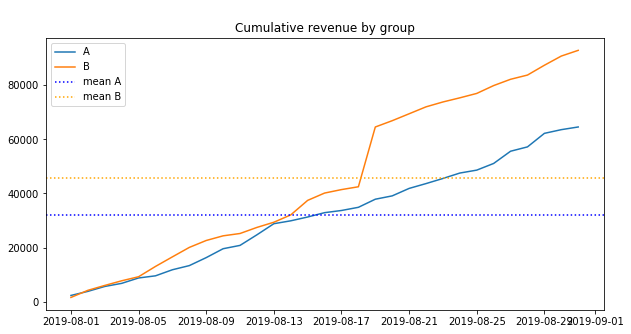

In [16]:
plt.figure(figsize=(10, 5))

plt.title('\nCumulative revenue by group')

# Plotting the group A revenue graph 
plt.plot(cum_data_pivoted['date'], cum_data_pivoted.revenueA, label='A')

# Plotting the group B revenue graph 
plt.plot(cum_data_pivoted['date'], cum_data_pivoted.revenueB, label='B')


plt.axhline(y=cum_data_pivoted.revenueA.mean(), color='blue', linestyle=':', label='mean A')
plt.axhline(y=cum_data_pivoted.revenueB.mean(), color='orange', linestyle=':', label='mean B')


plt.legend()
plt.show()

Revenue is rising in both groups throughout the whole test. After 2019-08-18 we can see a spike in revenue in group B. This may imply either a surge in the number of orders or the presence of very expensive orders in the sample. The mean values by group show an obvious difference.

### 2.	Graph `cumulative average order size` by group.

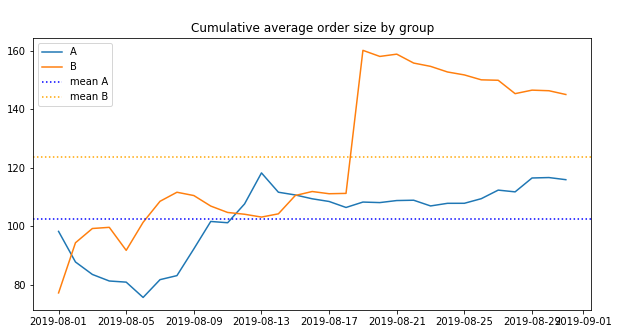

In [17]:
plt.figure(figsize=(10, 5))

plt.title('\nCumulative average order size by group')

# Plotting the group A revenue graph 
plt.plot(cum_data_pivoted['date'], cum_data_pivoted.avg_purchase_sizeA, label='A')

# Plotting the group B revenue graph 
plt.plot(cum_data_pivoted['date'], cum_data_pivoted.avg_purchase_sizeB, label='B')

plt.axhline(y=cum_data_pivoted.avg_purchase_sizeA.mean(), color='blue', linestyle=':', label='mean A')
plt.axhline(y=cum_data_pivoted.avg_purchase_sizeB.mean(), color='orange', linestyle=':', label='mean B')

plt.legend()
plt.show()

The significant spike after 2019-08-18 in group B is probably caused by large or expensive orders, but then the average order size stabilizes for group A and it starts to decrease slightly for group B. The mean values by group still show an obvious difference.

### 3.	Graph the `relative difference` in `cumulative average order size` for group B compared with group A.

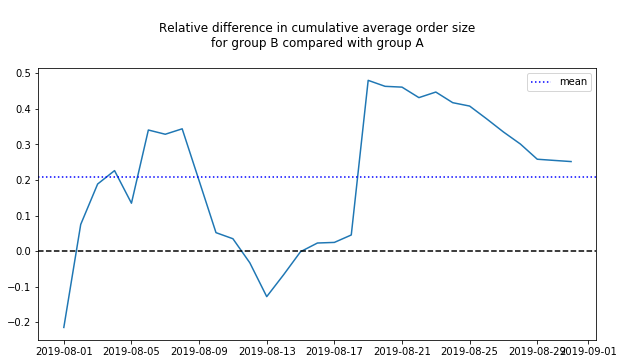

In [18]:

plt.figure(figsize=(10, 5))

plt.title('\nRelative difference in cumulative average order size\nfor group B compared with group A\n')
# plotting a relative difference graph for the average purchase sizes
plt.plot(cum_data_pivoted['date'], (cum_data_pivoted['avg_purchase_sizeB']/cum_data_pivoted['avg_purchase_sizeA']-1))

# adding the X axis
plt.axhline(y=(cum_data_pivoted['avg_purchase_sizeB']/cum_data_pivoted['avg_purchase_sizeA']-1).mean(), 
            color='blue', 
            linestyle=':', 
            label='mean')

plt.axhline(y=0, color='black', linestyle='--') 

plt.legend()
plt.show()

The curve follows the logic of the previous graph and shows two surges where the difference between groups  was significant. The `mean` value of the `relative difference` in cumulative average order size is about 20%.

### 4.	Calculate each group's `conversion rate` as the ratio of orders to the number of visits for each day.

Note, we've calculated two conversion metrics:

* Buyer Conversion Rate:

        data['buyer_conversion'] = data['buyers']/data['visitors']


* Order Conversion Rate:

        data['order_conversion'] = data['orders']/data['visitors']

They may look similar, but we should keep in mind that in extreme cases we may encounter results like this:

Buyer Conversion Rate:

$\frac{1\ visitor(with\ 100\ orders)}{100\ visitors}={conversion\ 1\%}$


Order Conversion Rate:

$\frac{1\ visitor(with\ 100\ orders)}{100\ visitors}={conversion\ 100\%}$

In our case there should be no surprises:

In [19]:
print(f'Average number of orders per user: {round((agg_data.orders/agg_data.buyers).mean(), 3)}')

Average number of orders per user: 1.023


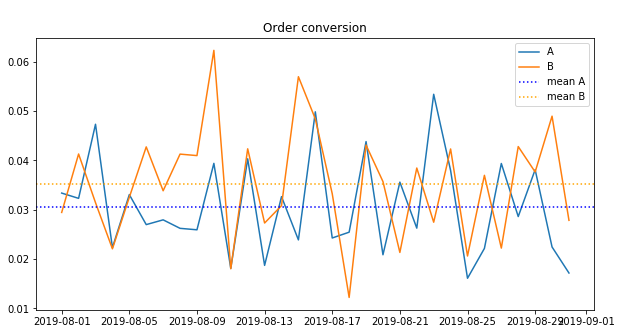

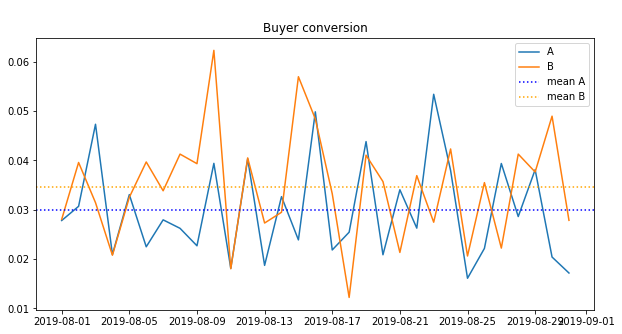

In [20]:
plt.figure(1, figsize=(10, 5))

plt.title('\nOrder conversion')
plt.plot(agg_data_pivoted['date'], agg_data_pivoted['order_conversionA'], label='A')
plt.plot(agg_data_pivoted['date'], agg_data_pivoted['order_conversionB'], label='B')

plt.axhline(y=agg_data_pivoted['order_conversionA'].mean(), color='blue', linestyle=':', label='mean A')
plt.axhline(y=agg_data_pivoted['order_conversionB'].mean(), color='orange', linestyle=':', label='mean B')

plt.legend()

plt.figure(2, figsize=(10, 5))

plt.title('\nBuyer conversion')

plt.plot(agg_data_pivoted['date'], agg_data_pivoted['buyer_conversionA'], label='A')
plt.plot(agg_data_pivoted['date'], agg_data_pivoted['buyer_conversionB'], label='B')

plt.axhline(y=agg_data_pivoted['buyer_conversionA'].mean(), color='blue', linestyle=':', label='mean A')
plt.axhline(y=agg_data_pivoted['buyer_conversionB'].mean(), color='orange', linestyle=':', label='mean B')


plt.legend()
plt.show()

* as we mentioned graphs for `Order conversion` and `Buyer conversion` look similar

* in both groups we can see fluctuations in range from 2% to 5%

* in group B there are two peaks (5.5% and 6%) and a drop (1%)

* mean value
    * for group B: 3.5%
    * for group A: 3%

#### Cumulative conversion

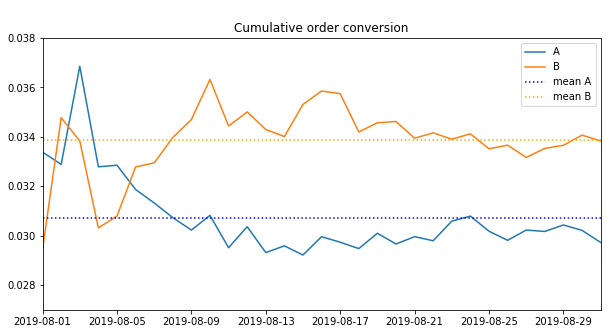

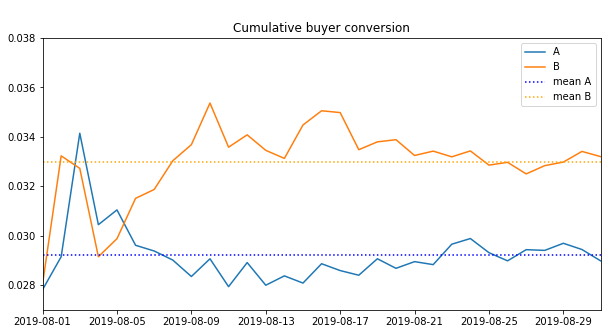

In [21]:
plt.figure(1, figsize=(10, 5))


plt.title('\nCumulative order conversion')
plt.plot(cum_data_pivoted['date'], cum_data_pivoted['order_conversionA'], label='A')
plt.plot(cum_data_pivoted['date'], cum_data_pivoted['order_conversionB'], label='B')

plt.axhline(y=cum_data_pivoted['order_conversionA'].mean(), color='blue', linestyle=':', label='mean A')
# plt.axhline(y=cum_data_pivoted['order_conversionA'].median(), color='blue', linestyle='--')
plt.axhline(y=cum_data_pivoted['order_conversionB'].mean(), color='orange', linestyle=':', label='mean B')
# plt.axhline(y=cum_data_pivoted['order_conversionB'].median(), color='orange', linestyle='--')

plt.legend()
plt.axis([cum_data_pivoted['date'].min(), cum_data_pivoted['date'].max(), 0.027, 0.038]) 


plt.figure(2, figsize=(10, 5))


plt.title('\nCumulative buyer conversion')

plt.plot(cum_data_pivoted['date'], cum_data_pivoted['buyer_conversionA'], label='A')
plt.plot(cum_data_pivoted['date'], cum_data_pivoted['buyer_conversionB'], label='B')

plt.axhline(y=cum_data_pivoted['buyer_conversionA'].mean(), color='blue', linestyle=':', label='mean A')
# plt.axhline(y=cum_data_pivoted['buyer_conversionA'].median(), color='blue', linestyle='--')
plt.axhline(y=cum_data_pivoted['buyer_conversionB'].mean(), color='orange', linestyle=':', label='mean B')
# plt.axhline(y=cum_data_pivoted['buyer_conversionB'].median(), color='orange', linestyle='--')

plt.legend()
plt.axis([cum_data_pivoted['date'].min(), cum_data_pivoted['date'].max(), 0.027, 0.038]) 
plt.show()

* after fluctuations in the first week both groups stabilized in last decade of the test
* mean value of Cumulative conversion in group B looks much better

#### `Relative gain` in `cumulative conversion` in group B as opposed to group A

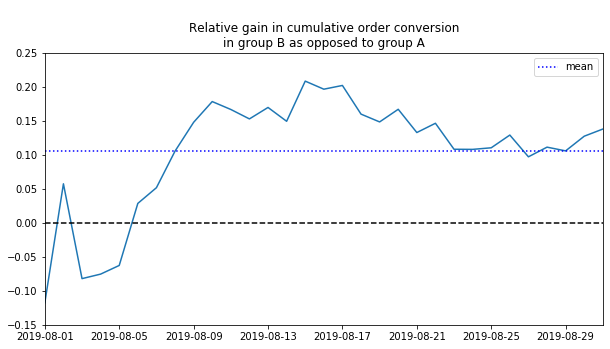

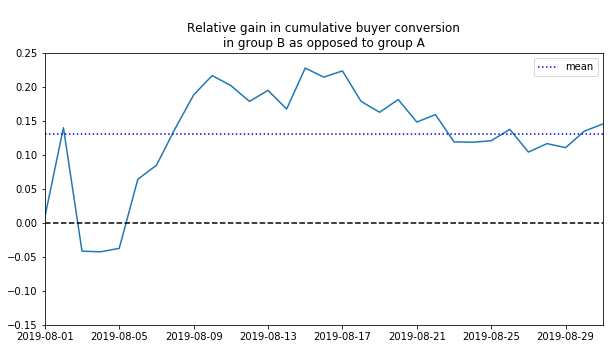

In [22]:
plt.figure(1, figsize=(10, 5))

plt.title("\nRelative gain in cumulative order conversion\nin group B as opposed to group A")
plt.plot(cum_data_pivoted['date'], 
         cum_data_pivoted['order_conversionB']/cum_data_pivoted['order_conversionA']-1)


plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=(cum_data_pivoted['order_conversionB']/cum_data_pivoted['order_conversionA']-1).mean(), 
            color='blue', 
            linestyle=':', 
            label='mean')

plt.axis([cum_data_pivoted['date'].min(), cum_data_pivoted['date'].max(), -0.15, 0.25])

plt.legend()

plt.figure(2, figsize=(10, 5))

plt.title("\nRelative gain in cumulative buyer conversion\nin group B as opposed to group A")
plt.plot(cum_data_pivoted['date'], 
         cum_data_pivoted['buyer_conversionB']/cum_data_pivoted['buyer_conversionA']-1)



plt.axhline(y=(cum_data_pivoted['buyer_conversionB']/cum_data_pivoted['buyer_conversionA']-1).mean(), 
            color='blue', 
            linestyle=':', 
            label='mean')
plt.axhline(y=0, color='black', linestyle='--')


plt.axis([cum_data_pivoted['date'].min(), cum_data_pivoted['date'].max(), -0.15, 0.25]) 
plt.legend()
plt.show()

After a drop in the first week of the test and subsequent surge, the `relative gain` stabilized around mean value.

In the `previous` pair of graphs we saw the `difference` between the means, 

and `here` we can see that mean value of `relative gain` in cumulative:

    order conversion: 10%
    buyer conversion: 14%
    
so we assume that group B may be more active

### 5.	Plot a scatter chart of the `number of orders` per user.

In [23]:
orders_per_user = df_orders.groupby('visitorId').agg({'transactionId':'nunique'})

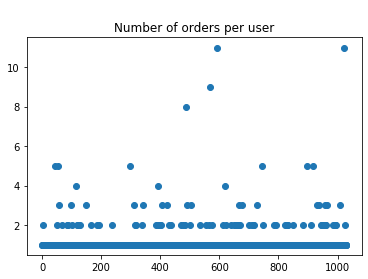

In [24]:
x_val = pd.Series(range(len(orders_per_user)))

plt.title('\nNumber of orders per user')
plt.scatter(x_val, orders_per_user)

plt.show()

We can that the majority of visitors placed only one order, some placed two.
Let's calculate percentiles for the number of orders per user:

### 6.	Calculate the `95th and 99th percentiles` for the number of orders per user.

In [25]:
orders_per_user.describe(percentiles=[.25, .5, .75, .95, .99]).T

,count,mean,std,min,25%,50%,75%,95%,99%,max
transactionId,1031.0,1.161009,0.724919,1.0,1.0,1.0,1.0,2.0,4.0,11.0


In [26]:
lst = orders_per_user.transactionId.sort_values()
percentiles = {x: round((i+1)/len(lst)*100, 2) for i, x in enumerate(lst)}
percentiles

{1: 90.88,
 2: 97.09,
 3: 98.74,
 4: 99.03,
 5: 99.61,
 8: 99.71,
 9: 99.81,
 11: 100.0}

In [27]:
orders_per_user.transactionId.value_counts(normalize=True)

1     0.908826
2     0.062076
3     0.016489
5     0.005820
4     0.002910
11    0.001940
9     0.000970
8     0.000970
Name: transactionId, dtype: float64

the share of visitors with more than 3 orders seems insignificant

we think that it would be reasonable to set the limit:
#### less than 99th percentile (number of orders < 4)

### 7.	Plot a scatter chart of `order prices`.

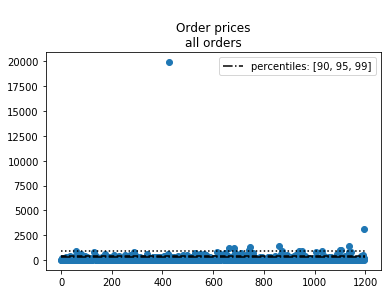

In [28]:
x_val = pd.Series(range(len(df_orders.revenue)))

plt.title('\nOrder prices\nall orders')
plt.scatter(x_val, df_orders.revenue)

plt.hlines(np.percentile(df_orders.revenue, [90, 95, 99]), 0, 1200, colors='k', linestyles=['-.','--',':'], 
           label='percentiles: [90, 95, 99]')

plt.legend()
plt.show()

Here we can see only two outliers, but let's take a closer look

### 8.	Calculate the `95th and 99th percentiles` of order prices.

In [29]:
df_orders[['revenue']].describe(percentiles=[.25, .5, .75, .95, .99]).T

,count,mean,std,min,25%,50%,75%,95%,99%,max
revenue,1197.0,131.491646,603.004729,5.0,20.8,50.2,130.4,435.54,900.904,19920.4


In [30]:
lst = df_orders.revenue.sort_values()
percentiles = {x: round((i+1)/len(lst)*100, 2) for i, x in enumerate(lst)}

list(percentiles.items())[-15:]

[(815.8, 98.5),
 (830.3, 98.75),
 (875.5, 98.83),
 (900.7, 99.0),
 (905.8, 99.08),
 (930.0, 99.16),
 (1015.9, 99.25),
 (1025.8, 99.33),
 (1050.0, 99.42),
 (1220.2, 99.58),
 (1335.6, 99.67),
 (1425.8, 99.75),
 (1450.2, 99.83),
 (3120.1, 99.92),
 (19920.4, 100.0)]

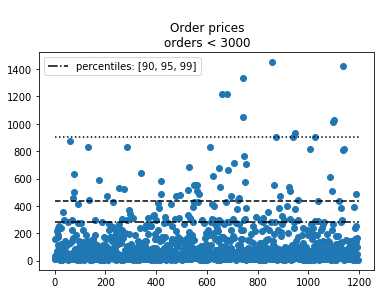

In [31]:
x_val = pd.Series(range(len(df_orders[df_orders['revenue'] < 3000]['revenue'])))

plt.title('\nOrder prices\norders < 3000')
plt.scatter(x_val, df_orders[df_orders['revenue'] < 3000]['revenue'])

plt.hlines(np.percentile(df_orders.revenue, [90, 95, 99]), 0, 1200, colors='k', linestyles=['-.','--',':'], 
           label='percentiles: [90, 95, 99]')


plt.legend()
plt.show()

#### here we've filtered only two orders
#### now let's try the limit on the 99th percentile:

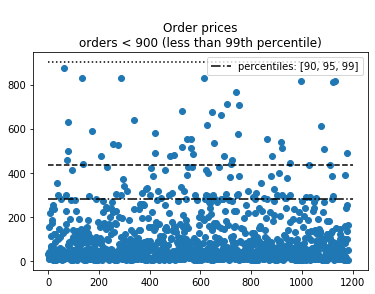

In [32]:
x_val = pd.Series(range(len(df_orders[df_orders['revenue'] < 900]['revenue'])))

plt.title('\nOrder prices\norders < 900 (less than 99th percentile)')
plt.scatter(x_val, df_orders[df_orders['revenue'] < 900]['revenue'])

plt.hlines(np.percentile(df_orders.revenue, [90, 95, 99]), 0, 1200, colors='k', linestyles=['-.','--',':'], 
           label='percentiles: [90, 95, 99]')


plt.legend()
plt.show()

#### it looks much better
#### but now let's try the limit on the 95th percentile:

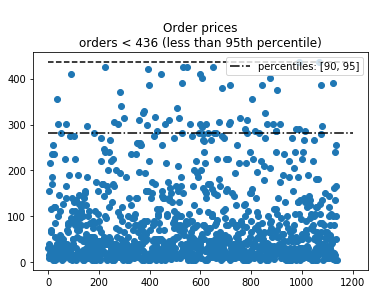

In [33]:
x_val = pd.Series(range(len(df_orders[df_orders['revenue'] < 436]['revenue'])))

plt.title('\nOrder prices\norders < 436 (less than 95th percentile)')
plt.scatter(x_val, df_orders[df_orders['revenue'] < 436]['revenue'])

plt.hlines(np.percentile(df_orders.revenue, [90, 95]), 0, 1200, colors='k', linestyles=['-.','--'], 
           label='percentiles: [90, 95]')


plt.legend()
plt.show()

#### we think that it would be reasonable to stop and to set the limit:
#### less than 99th percentile (order price < 900)

### 9.	Find the `statistical significance` of the difference in `conversion` between the groups using the raw data.

In [34]:
sample_A = pd.concat([pd.Series(0, range(agg_data_pivoted.not_buyersA.sum()), name='orders'), 
                         pd.Series(1, range(agg_data_pivoted.buyersA.sum()), name='orders')]).reset_index()['orders']

sample_B = pd.concat([pd.Series(0, range(agg_data_pivoted.not_buyersB.sum()), name='orders'), 
                         pd.Series(1, range(agg_data_pivoted.buyersB.sum()), name='orders')]).reset_index()['orders']

p_value = stats.mannwhitneyu(sample_A, sample_B)[1]

print('\nThe difference in conversion between the groups using the raw data\n')

print("p-value: {0:.3f}".format(p_value))

print("\nrelative order conversion gain: {0:.3f}".format(
            (agg_data_pivoted.ordersB.sum() / agg_data_pivoted.visitorsB.sum())/\
                    (agg_data_pivoted.ordersA.sum() / agg_data_pivoted.visitorsA.sum()) - 1))

print('\nbuyers_B_conv_rate: {0:.3f}'.format(
      (agg_data_pivoted.buyersB.sum() / agg_data_pivoted.visitorsB.sum())),
      '\nbuyers_A_conv_rate {0:.3f}:'.format(
      (agg_data_pivoted.buyersA.sum() / agg_data_pivoted.visitorsA.sum())),
      
      "\nrelative buyers conversion gain: {0:.3f}".format(
            (agg_data_pivoted.buyersB.sum() / agg_data_pivoted.visitorsB.sum())/\
                    (agg_data_pivoted.buyersA.sum() / agg_data_pivoted.visitorsA.sum()) - 1))


The difference in conversion between the groups using the raw data

p-value: 0.009

relative order conversion gain: 0.138

buyers_B_conv_rate: 0.033 
buyers_A_conv_rate 0.029: 
relative buyers conversion gain: 0.146


#### Conclusion: based on the `raw` data, there is a `difference` between groups A and B.

The `p-value`: 0.009, which is `less` than 0.05. 

#### We `reject` the null hypothesis that there's no statistically significant difference in conversion between the groups. 

* the relative order conversion gain: 13.8%

* the relative buyers conversion gain: 14.6%

### 10.	Find the `statistical significance` of the difference in `average order size` between the groups using the raw data.
Make conclusions and conjectures.

In [35]:
sample_A = agg_data_pivoted.avg_purchase_sizeA
sample_B = agg_data_pivoted.avg_purchase_sizeB

p_value = stats.mannwhitneyu(sample_A, sample_B)[1]

print('\nThe difference in average order size between the groups using the raw data\n')
print("p-value: {0:.3f}".format(p_value))

print("\nThe relative difference in average order: {0:.3f}".format(sample_B.mean()/sample_A.mean()-1)) 


The difference in average order size between the groups using the raw data

p-value: 0.211

The relative difference in average order: 0.238


#### Conclusion: based on the `raw` data, there is `no difference` in average order size between the groups.

The `p-value` is considerably `higher` than 0.05 

#### We `can't reject` the null hypothesis. 

The `average order size` for group B is much `greater` than it is for group A by 23.8%.

#### xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

### Preparing filtered data:

* number of orders < 4 (less than 99th percentile)
* order price < 900 (less than 99th percentile)

In [36]:
multiple_orders = df_orders.groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
multiple_orders = multiple_orders[multiple_orders['transactionId'] > 3] #
multiple_orders[['transactionId']].describe().T

,count,mean,std,min,25%,50%,75%,max
transactionId,13.0,6.230769,2.586949,4.0,5.0,5.0,8.0,11.0


In [37]:
expensive_orders = df_orders[df_orders['revenue'] >= 900]
expensive_orders[['revenue']].describe().T

,count,mean,std,min,25%,50%,75%,max
revenue,14.0,2601.528571,5016.881882,900.7,951.475,1135.1,1403.25,19920.4


In [38]:
filtered_users = pd.concat([multiple_orders['visitorId'], expensive_orders['visitorId']]).drop_duplicates().sort_values()
len(filtered_users)

24

In [39]:

filtered_data = df_visits.merge(df_orders[~df_orders['visitorId'].isin(filtered_users)]\
                                        .groupby(['visitorId','date','group'], as_index=False)\
                                        .agg({'transactionId':'nunique','revenue':'sum'})\
                                        .groupby(['date', 'group'], as_index=False)\
                                        .agg({'visitorId':'nunique','transactionId':'sum','revenue':'sum'}),
                                   on=['date', 'group'])

filtered_data.columns = ['date','group','visitors','buyers','orders','revenue']


filtered_data['avg_purchase_size'] = round(filtered_data['revenue'] / filtered_data['orders'], 2)

# calculating conversion
# Buyer Conversion Rate:
filtered_data['buyer_conversion'] = filtered_data['buyers']/filtered_data['visitors']

# Order Conversion Rate:
filtered_data['order_conversion'] = filtered_data['orders']/filtered_data['visitors']

filtered_data['not_buyers'] = filtered_data['visitors'] - filtered_data['buyers']

filtered_data.head(3)

,date,group,visitors,buyers,orders,revenue,avg_purchase_size,buyer_conversion,order_conversion,not_buyers
0,2019-08-01,A,719,19,23,2266.6,98.55,0.026426,0.031989,700
1,2019-08-02,A,619,19,20,1503.5,75.18,0.030695,0.032310,600
2,2019-08-03,A,507,24,24,1815.2,75.63,0.047337,0.047337,483


In [40]:
filtered_data_pivoted = filtered_data.pivot_table(index='date', 
                                                    columns='group', 
                                                    values=['visitors','not_buyers','buyers','orders',
                                                            'revenue','avg_purchase_size',
                                                            'buyer_conversion','order_conversion']).reset_index()

filtered_data_pivoted.columns = [''.join(i) for i in filtered_data_pivoted.columns]


# relative buyers conversion gain for group B
filtered_data_pivoted['rel_buyer_conversion_gain_B'] = round(filtered_data_pivoted.buyer_conversionB/\
                                                        filtered_data_pivoted.buyer_conversionA - 1, 3)

# relative order conversion gain for group B
filtered_data_pivoted['rel_order_conversion_gain_B'] = round(filtered_data_pivoted.order_conversionB/\
                                                        filtered_data_pivoted.order_conversionA - 1, 3)

filtered_data_pivoted.head(3)

,date,avg_purchase_sizeA,avg_purchase_sizeB,buyer_conversionA,buyer_conversionB,buyersA,buyersB,not_buyersA,not_buyersB,order_conversionA,order_conversionB,ordersA,ordersB,revenueA,revenueB,visitorsA,visitorsB,rel_buyer_conversion_gain_B,rel_order_conversion_gain_B
0,2019-08-01,98.55,66.25,0.026426,0.026648,19,19,700,694,0.031989,0.026648,23,19,2266.6,1258.8,719,713,0.008,-0.167
1,2019-08-02,75.18,111.66,0.030695,0.037866,19,22,600,559,0.032310,0.039587,20,23,1503.5,2568.1,619,581,0.234,0.225
2,2019-08-03,75.63,112.92,0.047337,0.031434,24,16,483,493,0.047337,0.031434,24,16,1815.2,1806.8,507,509,-0.336,-0.336


In [41]:
(filtered_data_pivoted.sum()/agg_data_pivoted.sum()-1).round(3)

avg_purchase_sizeA            -0.086
avg_purchase_sizeB            -0.288
buyer_conversionA             -0.079
buyer_conversionB             -0.061
buyersA                       -0.081
buyersB                       -0.064
not_buyersA                    0.002
not_buyersB                    0.002
order_conversionA             -0.082
order_conversionB             -0.070
ordersA                       -0.084
ordersB                       -0.073
revenueA                      -0.181
revenueB                      -0.350
visitorsA                      0.000
visitorsB                      0.000
rel_buyer_conversion_gain_B    0.248
rel_order_conversion_gain_B    0.231
dtype: float64

#### xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

### 11.	Find the `statistical significance` of the difference in `conversion` between the groups using the `filtered` data. 
Make conclusions and conjectures.

In [42]:
sample_A = pd.concat([pd.Series(0, range(filtered_data_pivoted.not_buyersA.sum()), name='orders'), 
                         pd.Series(1, range(filtered_data_pivoted.buyersA.sum()), name='orders')]).reset_index()['orders']

sample_B = pd.concat([pd.Series(0, range(filtered_data_pivoted.not_buyersB.sum()), name='orders'), 
                         pd.Series(1, range(filtered_data_pivoted.buyersB.sum()), name='orders')]).reset_index()['orders']

p_value = stats.mannwhitneyu(sample_A, sample_B)[1]


print('\nThe difference in conversion between the groups using the filtered data\n')
print("p-value: {0:.3f}".format(p_value))

print("\nrelative order conversion gain: {0:.3f}".format(
            (filtered_data_pivoted.ordersB.sum() / filtered_data_pivoted.visitorsB.sum())/\
                    (filtered_data_pivoted.ordersA.sum() / filtered_data_pivoted.visitorsA.sum()) - 1))

print('\nbuyers_B_conv_rate: {0:.3f}'.format(
      (filtered_data_pivoted.buyersB.sum() / filtered_data_pivoted.visitorsB.sum())),
      '\nbuyers_A_conv_rate {0:.3f}:'.format(
      (filtered_data_pivoted.buyersA.sum() / filtered_data_pivoted.visitorsA.sum())),
      
      "\nrelative buyers conversion gain: {0:.3f}".format(
            (filtered_data_pivoted.buyersB.sum() / filtered_data_pivoted.visitorsB.sum())/\
                    (filtered_data_pivoted.buyersA.sum() / filtered_data_pivoted.visitorsA.sum()) - 1))


The difference in conversion between the groups using the filtered data

p-value: 0.005

relative order conversion gain: 0.152

buyers_B_conv_rate: 0.031 
buyers_A_conv_rate 0.027: 
relative buyers conversion gain: 0.167


`For comparison`, results using the `raw` data:

    p-value: 0.009
    
    the relative order conversion gain: 13.8%
    the relative buyers conversion gain: 14.6%
    

    
#### Conclusion: based on the `filtered` data, there is a `difference` between groups A and B.

The `p-value`: 0.005, which is `less` than 0.05. 

#### So we `reject the null hypothesis` that there's no statistically significant difference in conversion between the groups. 

* the relative order conversion gain: 15.2%
* the relative buyers conversion gain: 16.7%

### 12.	Find the `statistical significance` of the difference in `average order size` between the groups using the `filtered` data. 
Make conclusions and conjectures.

In [43]:
sample_A = filtered_data_pivoted.avg_purchase_sizeA
sample_B = filtered_data_pivoted.avg_purchase_sizeB

p_value = stats.mannwhitneyu(sample_A, sample_B)[1]
# p_value2 = stats.ttest_ind(sample_A, sample_B)[1]
# p_value3 = stats.ttest_ind(sample_A, sample_B, equal_var=False)[1]

print('\nThe difference in average order size between the groups using the filtered data\n')
print("p-value: {0:.3f}".format(p_value))
# print("p-value2: {0:.4f}".format(p_value2))
# print("p-value3: {0:.4f}".format(p_value3))


print("\nThe relative difference in average order: {0:.3f}".format(sample_B.mean()/sample_A.mean()-1)) 


The difference in average order size between the groups using the filtered data

p-value: 0.400

The relative difference in average order: -0.036


`For comparison`, result using the `raw` data:

    p-value: 0.21114

#### Conclusion: based on the `filtered` data, there is `no difference` in average order size between the groups.

`p-value`: 0.400

The `p-value` is considerably `higher` than 0.05 

#### We `can't reject` the null hypothesis. 

The `average order size` for group B is much `smaller` than it is for group A by 3.6%.

### 13.	Make a decision based on the test results. 

There's a statistically significant difference in conversion between the groups, according to both the raw and the filtered data.

The raw and the filtered data didn't show a statistically significant difference between the groups in terms of average purchase size.

The graph of the difference in conversion between the groups shows that group B's results are better than those of group A: they have a tendency to grow or have stabilized around the mean.

Our decision:

* to stop the test, 
* to consider the B group the leader. 

## Part 3. Conclusion


#### Our task was 
* to prioritize the hypotheses
* to analyze the A/B test results.

#### We prioritized hypotheses using the ICE and RICE frameworks:  

rank_ICE #1 Hypothesis:
* Launch a promotion that gives users discounts on their birthdays

rank_RICE #1 Hypothesis:
* Add a subscription form to all the main pages. This will help you compile a mailing list

We discovered that the 'Reach' parameter has significant impact on results.

The difference between ICE and RICE ranks:

    rank_ICE  rank_RICE
         3          1
         5          2
         2          3
         4          3
         1          5

#### We analyzed the results of an A/B test

    cumulative revenue
    cumulative average order size by group
    the relative difference in cumulative average order size
    conversion rate

#### We set the limits for the filtered data:
less than 99th percentile:
* number of orders < 4
* order price < 900




#### Based on the raw and filtered data, we defined if there is the statistical significance of the difference between the groups:  

    in conversion 
    in average order size
    
#### We discovered:

* There's a `statistically significant` difference in `conversion` between the groups (for the raw and the filtered data).    
* There's `no statistically significant` difference in `average purchase size` between the groups (for the raw and the filtered data).
* The graph of the difference in conversion between the groups shows that `group B`'s results are `better` than those of `group A`: they have a tendency to grow or have stabilized around the mean.

#### We think that we should:

* stop the test 
* consider the B group the leader. 